<a href="https://colab.research.google.com/github/smitasasindran/era4/blob/session7/Session7/ERA4_Session7_Iteration4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding albumentations transformations





## Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import numpy as np


In [ ]:
!pip install albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

## Data Transformations

In [ ]:

train_transforms = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        # A.RandomBrightnessContrast(p=0.5),
        A.CoarseDropout(p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,
                        fill_value=(0.4914, 0.4822, 0.4465), mask_fill_value = None),
        A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)), # CIFAR-10 mean/std
        ToTensorV2(),
    ])

test_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2471, 0.2435, 0.2616)),
    ToTensorV2(),
])


/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-4017075348.py:5: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(p=0.5, max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, min_width=16,


## Creating new dataset class

In [ ]:
from torch.utils.data import Dataset

class CIFAR10Albumentations(Dataset):
    def __init__(self, root, train=True, download=True, transform=None):
        self.cifar10 = datasets.CIFAR10(root=root, train=train, download=download)
        self.transform = transform

    def __len__(self):
        return len(self.cifar10)

    def __getitem__(self, idx):
        image, label = self.cifar10[idx]
        # Albumentations expects NumPy arrays, so convert PIL Image
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

## Dataset and Creating Train/Test Split


In [ ]:
# train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
# test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

train = CIFAR10Albumentations(root='./data', train=True, download=True, transform=train_transforms)
test = CIFAR10Albumentations(root='./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170M/170M [00:02<00:00, 70.4MB/s]


# Dataloader Arguments & Test/Train Dataloaders

In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

batch_size = 512#256
cpu_batch_size = 128#64
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=cpu_batch_size)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Data Statistics

torch.Size([512, 3, 32, 32])
torch.Size([512])


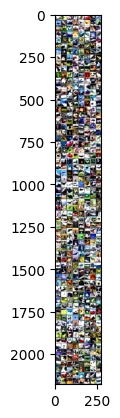

ship  bird  cat   dog   bird  truck truck plane plane ship  truck frog  bird  bird  dog   frog  ship  deer  horse truck horse horse dog   cat   cat   truck ship  plane car   truck frog  frog  bird  deer  frog  plane deer  truck car   car   horse cat   deer  ship  truck plane frog  ship  plane cat   bird  bird  frog  frog  plane truck cat   bird  ship  bird  bird  deer  bird  frog  ship  deer  deer  truck truck deer  horse cat   dog   truck truck dog   deer  car   dog   car   dog   dog   deer  truck bird  frog  ship  dog   ship  dog   frog  ship  car   dog   car   horse ship  frog  deer  deer  ship  cat   cat   frog  horse ship  horse car   car   truck bird  bird  dog   ship  truck cat   ship  deer  deer  dog   car   ship  dog   horse deer  cat   deer  car   dog   plane bird  truck cat   cat   cat   ship  horse frog  plane dog   bird  truck frog  dog   car   car   horse plane truck cat   bird  car   cat   car   deer  car   ship  horse plane frog  dog   truck deer  bird  car   deer  hors

In [ ]:
# Check some images

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# img = np.moveaxis(images[0].numpy(), 0, -1)
# plt.imshow(img)

def imshow(img):
        img = img / 2 + 0.5  # Unnormalize
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.show()


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(len(labels))))



# figure = plt.figure()
# num_of_images = 60
# for index in range(1, num_of_images + 1):
#     plt.subplot(6, 10, index)
#     plt.axis('off')
#     plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Define the model

In [ ]:
#https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch
def depthwise_separable_layer(nin, nout, dropout_value, padding=0):
    depthwise = nn.Conv2d(nin, nin, kernel_size=3, padding=padding, groups=nin, bias=False)
    pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=False)

    depthwise_separable = nn.Sequential(
        depthwise,
        nn.ReLU(),
        nn.BatchNorm2d(nin),
        nn.Dropout(dropout_value),
        pointwise,
        nn.ReLU(),
        nn.BatchNorm2d(nout),
        nn.Dropout(dropout_value)
    )
    return depthwise_separable


In [ ]:
# updated -- more kernels

dropout_value = 0.1

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()

        # Conv Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=3

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=5

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32, rf=7

        # transition 1 - use stride2 instead of MP
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, stride=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=9
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=9

        # Conv Block 2 -------------------
        self.conv6 = nn.Sequential( # padding
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=13 (jump2)

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=17

        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=21

        # Transition 2 --
        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=21


        # Conv Block 3 ---------------------
        self.conv10 = nn.Sequential( # padding
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 15, rf=25

        self.conv11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 13, rf=29

        # self.conv12 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(32),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 11, rf=33
        self.conv12 = depthwise_separable_layer(32, 64, dropout_value, padding=0) # output_size=11, rf=33

        # transition 3
        self.conv13 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 11, rf=33

        # Conv Block 4 - with dilation
        self.conv14 = nn.Sequential( # Dilation
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, dilation=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 7, rf=41 # dilation

        self.conv15 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 5, rf=45

        # self.conv16 = nn.Sequential(
        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
        #     nn.ReLU(),
        #     nn.BatchNorm2d(64),
        #     nn.Dropout(dropout_value)
        # ) # output_size = 6


        # Output
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 5

        self.conv17 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.Dropout(dropout_value)
            # nn.ReLU()
        ) # output_size = 10, rf=45



    def forward(self, x):
        # block1
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x) # stride 2
        # print(f"conv4 out: {x.shape}")

        # block2
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)

        # block3
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.conv11(x)
        x = self.conv12(x)

        # block4
        x = self.conv13(x)
        x = self.conv14(x)
        x = self.conv15(x)
        # x = self.conv16(x)
        # print(f"conv15 out: {x.shape}")

        # Output
        x = self.gap(x)
        x = self.conv17(x)
        x = x.view(-1, 10)

        return F.log_softmax(x, dim=-1)




## Model Summary

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
              ReLU-2           [-1, 16, 32, 32]               0
       BatchNorm2d-3           [-1, 16, 32, 32]              32
           Dropout-4           [-1, 16, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]           4,608
              ReLU-6           [-1, 32, 32, 32]               0
       BatchNorm2d-7           [-1, 32, 32, 32]              64
           Dropout-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
          Dropout-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 15, 15]          18,432
             ReLU-14           [-1

## Train and Test loops

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

## Training

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=1.753972053527832 Batch_id=97 Accuracy=23.86: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 1.9009, Accuracy: 2927/10000 (29.27%)

EPOCH: 1


Loss=1.5241597890853882 Batch_id=97 Accuracy=38.33: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 1.4756, Accuracy: 4529/10000 (45.29%)

EPOCH: 2


Loss=1.3967534303665161 Batch_id=97 Accuracy=46.10: 100%|██████████| 98/98 [00:21<00:00,  4.50it/s]



Test set: Average loss: 1.3916, Accuracy: 4877/10000 (48.77%)

EPOCH: 3


Loss=1.2786712646484375 Batch_id=97 Accuracy=50.95: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 1.3257, Accuracy: 5195/10000 (51.95%)

EPOCH: 4


Loss=1.3564571142196655 Batch_id=97 Accuracy=54.62: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 1.1884, Accuracy: 5688/10000 (56.88%)

EPOCH: 5


Loss=1.1291052103042603 Batch_id=97 Accuracy=57.15: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 1.0996, Accuracy: 6075/10000 (60.75%)

EPOCH: 6


Loss=0.9947389960289001 Batch_id=97 Accuracy=59.81: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 1.0500, Accuracy: 6328/10000 (63.28%)

EPOCH: 7


Loss=0.8593252301216125 Batch_id=97 Accuracy=62.13: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.9696, Accuracy: 6528/10000 (65.28%)

EPOCH: 8


Loss=0.9313853979110718 Batch_id=97 Accuracy=63.50: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.9222, Accuracy: 6739/10000 (67.39%)

EPOCH: 9


Loss=0.9589013457298279 Batch_id=97 Accuracy=64.90: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]



Test set: Average loss: 0.9136, Accuracy: 6796/10000 (67.96%)

EPOCH: 10


Loss=0.9210913777351379 Batch_id=97 Accuracy=66.32: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.9012, Accuracy: 6885/10000 (68.85%)

EPOCH: 11


Loss=0.9088644981384277 Batch_id=97 Accuracy=67.36: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.8206, Accuracy: 7138/10000 (71.38%)

EPOCH: 12


Loss=0.8398165702819824 Batch_id=97 Accuracy=68.67: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.8257, Accuracy: 7092/10000 (70.92%)

EPOCH: 13


Loss=0.8912279009819031 Batch_id=97 Accuracy=69.58: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.8149, Accuracy: 7139/10000 (71.39%)

EPOCH: 14


Loss=0.797156572341919 Batch_id=97 Accuracy=70.12: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.7781, Accuracy: 7281/10000 (72.81%)

EPOCH: 15


Loss=0.7209193706512451 Batch_id=97 Accuracy=70.87: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.7706, Accuracy: 7327/10000 (73.27%)

EPOCH: 16


Loss=0.8685701489448547 Batch_id=97 Accuracy=71.86: 100%|██████████| 98/98 [00:22<00:00,  4.42it/s]



Test set: Average loss: 0.7523, Accuracy: 7400/10000 (74.00%)

EPOCH: 17


Loss=0.8573058843612671 Batch_id=97 Accuracy=72.41: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.7218, Accuracy: 7521/10000 (75.21%)

EPOCH: 18


Loss=0.6808604001998901 Batch_id=97 Accuracy=73.08: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.6989, Accuracy: 7593/10000 (75.93%)

EPOCH: 19


Loss=0.7957997918128967 Batch_id=97 Accuracy=73.53: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.6943, Accuracy: 7592/10000 (75.92%)

EPOCH: 20


Loss=0.7392798662185669 Batch_id=97 Accuracy=73.90: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.6891, Accuracy: 7630/10000 (76.30%)

EPOCH: 21


Loss=0.7285904288291931 Batch_id=97 Accuracy=74.26: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]



Test set: Average loss: 0.6810, Accuracy: 7669/10000 (76.69%)

EPOCH: 22


Loss=0.6903203725814819 Batch_id=97 Accuracy=74.96: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.6524, Accuracy: 7767/10000 (77.67%)

EPOCH: 23


Loss=0.7247782349586487 Batch_id=97 Accuracy=75.24: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 0.6371, Accuracy: 7816/10000 (78.16%)

EPOCH: 24


Loss=0.7504949569702148 Batch_id=97 Accuracy=75.74: 100%|██████████| 98/98 [00:20<00:00,  4.67it/s]



Test set: Average loss: 0.6305, Accuracy: 7808/10000 (78.08%)

EPOCH: 25


Loss=0.8365539312362671 Batch_id=97 Accuracy=75.83: 100%|██████████| 98/98 [00:19<00:00,  4.97it/s]



Test set: Average loss: 0.6312, Accuracy: 7829/10000 (78.29%)

EPOCH: 26


Loss=0.639457643032074 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.6466, Accuracy: 7787/10000 (77.87%)

EPOCH: 27


Loss=0.6695166826248169 Batch_id=97 Accuracy=76.58: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.6195, Accuracy: 7887/10000 (78.87%)

EPOCH: 28


Loss=0.682982325553894 Batch_id=97 Accuracy=76.91: 100%|██████████| 98/98 [00:20<00:00,  4.83it/s]



Test set: Average loss: 0.6038, Accuracy: 7933/10000 (79.33%)

EPOCH: 29


Loss=0.5929284691810608 Batch_id=97 Accuracy=77.04: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.5853, Accuracy: 7995/10000 (79.95%)

EPOCH: 30


Loss=0.619652271270752 Batch_id=97 Accuracy=77.51: 100%|██████████| 98/98 [00:22<00:00,  4.44it/s]



Test set: Average loss: 0.5764, Accuracy: 8028/10000 (80.28%)

EPOCH: 31


Loss=0.6872187852859497 Batch_id=97 Accuracy=77.92: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.5810, Accuracy: 8024/10000 (80.24%)

EPOCH: 32


Loss=0.5668814778327942 Batch_id=97 Accuracy=77.87: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.5698, Accuracy: 8063/10000 (80.63%)

EPOCH: 33


Loss=0.6521103382110596 Batch_id=97 Accuracy=77.91: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]



Test set: Average loss: 0.5619, Accuracy: 8080/10000 (80.80%)

EPOCH: 34


Loss=0.6255692839622498 Batch_id=97 Accuracy=78.39: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.5742, Accuracy: 8035/10000 (80.35%)

EPOCH: 35


Loss=0.6221213340759277 Batch_id=97 Accuracy=78.51: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.5529, Accuracy: 8106/10000 (81.06%)

EPOCH: 36


Loss=0.5932806730270386 Batch_id=97 Accuracy=78.78: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.5632, Accuracy: 8084/10000 (80.84%)

EPOCH: 37


Loss=0.5652779340744019 Batch_id=97 Accuracy=79.03: 100%|██████████| 98/98 [00:21<00:00,  4.49it/s]



Test set: Average loss: 0.5583, Accuracy: 8065/10000 (80.65%)

EPOCH: 38


Loss=0.5488682389259338 Batch_id=97 Accuracy=78.97: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.5620, Accuracy: 8073/10000 (80.73%)

EPOCH: 39


Loss=0.5154783129692078 Batch_id=97 Accuracy=79.17: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.5278, Accuracy: 8204/10000 (82.04%)

EPOCH: 40


Loss=0.5766369700431824 Batch_id=97 Accuracy=79.42: 100%|██████████| 98/98 [00:20<00:00,  4.81it/s]



Test set: Average loss: 0.5356, Accuracy: 8196/10000 (81.96%)

EPOCH: 41


Loss=0.5146296620368958 Batch_id=97 Accuracy=79.27: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.5425, Accuracy: 8114/10000 (81.14%)

EPOCH: 42


Loss=0.7561765313148499 Batch_id=97 Accuracy=79.62: 100%|██████████| 98/98 [00:19<00:00,  4.93it/s]



Test set: Average loss: 0.5277, Accuracy: 8204/10000 (82.04%)

EPOCH: 43


Loss=0.5646966099739075 Batch_id=97 Accuracy=79.85: 100%|██████████| 98/98 [00:20<00:00,  4.90it/s]



Test set: Average loss: 0.5229, Accuracy: 8213/10000 (82.13%)

EPOCH: 44


Loss=0.5465604662895203 Batch_id=97 Accuracy=79.81: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.5235, Accuracy: 8217/10000 (82.17%)

EPOCH: 45


Loss=0.5436162948608398 Batch_id=97 Accuracy=79.96: 100%|██████████| 98/98 [00:21<00:00,  4.48it/s]



Test set: Average loss: 0.5237, Accuracy: 8260/10000 (82.60%)

EPOCH: 46


Loss=0.5902099609375 Batch_id=97 Accuracy=80.01: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.5153, Accuracy: 8233/10000 (82.33%)

EPOCH: 47


Loss=0.6473076939582825 Batch_id=97 Accuracy=80.28: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.5176, Accuracy: 8267/10000 (82.67%)

EPOCH: 48


Loss=0.6415608525276184 Batch_id=97 Accuracy=80.70: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.5199, Accuracy: 8260/10000 (82.60%)

EPOCH: 49


Loss=0.5882654786109924 Batch_id=97 Accuracy=80.59: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.5102, Accuracy: 8273/10000 (82.73%)

EPOCH: 50


Loss=0.5929384231567383 Batch_id=97 Accuracy=80.65: 100%|██████████| 98/98 [00:19<00:00,  4.94it/s]



Test set: Average loss: 0.5105, Accuracy: 8236/10000 (82.36%)

EPOCH: 51


Loss=0.5775097608566284 Batch_id=97 Accuracy=80.62: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.5068, Accuracy: 8280/10000 (82.80%)

EPOCH: 52


Loss=0.4491386413574219 Batch_id=97 Accuracy=80.62: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]



Test set: Average loss: 0.4876, Accuracy: 8360/10000 (83.60%)

EPOCH: 53


Loss=0.5757788419723511 Batch_id=97 Accuracy=81.06: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.5149, Accuracy: 8282/10000 (82.82%)

EPOCH: 54


Loss=0.6199793815612793 Batch_id=97 Accuracy=81.34: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]



Test set: Average loss: 0.4972, Accuracy: 8334/10000 (83.34%)

EPOCH: 55


Loss=0.6223045587539673 Batch_id=97 Accuracy=81.22: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4747, Accuracy: 8409/10000 (84.09%)

EPOCH: 56


Loss=0.6375888586044312 Batch_id=97 Accuracy=81.35: 100%|██████████| 98/98 [00:19<00:00,  5.04it/s]



Test set: Average loss: 0.4845, Accuracy: 8365/10000 (83.65%)

EPOCH: 57


Loss=0.5315560698509216 Batch_id=97 Accuracy=81.53: 100%|██████████| 98/98 [00:20<00:00,  4.84it/s]



Test set: Average loss: 0.4752, Accuracy: 8369/10000 (83.69%)

EPOCH: 58


Loss=0.5976948738098145 Batch_id=97 Accuracy=81.56: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.5029, Accuracy: 8318/10000 (83.18%)

EPOCH: 59


Loss=0.5353164076805115 Batch_id=97 Accuracy=81.74: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.4820, Accuracy: 8420/10000 (84.20%)

EPOCH: 60


Loss=0.4803068935871124 Batch_id=97 Accuracy=81.62: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.4936, Accuracy: 8354/10000 (83.54%)

EPOCH: 61


Loss=0.56059730052948 Batch_id=97 Accuracy=81.56: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4716, Accuracy: 8427/10000 (84.27%)

EPOCH: 62


Loss=0.5668694376945496 Batch_id=97 Accuracy=81.53: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.4752, Accuracy: 8401/10000 (84.01%)

EPOCH: 63


Loss=0.5049907565116882 Batch_id=97 Accuracy=81.91: 100%|██████████| 98/98 [00:19<00:00,  5.02it/s]



Test set: Average loss: 0.4723, Accuracy: 8437/10000 (84.37%)

EPOCH: 64


Loss=0.5078348517417908 Batch_id=97 Accuracy=82.05: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4837, Accuracy: 8400/10000 (84.00%)

EPOCH: 65


Loss=0.5558266043663025 Batch_id=97 Accuracy=82.19: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.4729, Accuracy: 8438/10000 (84.38%)

EPOCH: 66


Loss=0.4622597396373749 Batch_id=97 Accuracy=82.01: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]



Test set: Average loss: 0.4672, Accuracy: 8427/10000 (84.27%)

EPOCH: 67


Loss=0.5840407609939575 Batch_id=97 Accuracy=82.17: 100%|██████████| 98/98 [00:19<00:00,  4.95it/s]



Test set: Average loss: 0.4665, Accuracy: 8427/10000 (84.27%)

EPOCH: 68


Loss=0.4911564886569977 Batch_id=97 Accuracy=82.13: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4683, Accuracy: 8441/10000 (84.41%)

EPOCH: 69


Loss=0.43391573429107666 Batch_id=97 Accuracy=82.25: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4660, Accuracy: 8411/10000 (84.11%)

EPOCH: 70


Loss=0.5539339780807495 Batch_id=97 Accuracy=82.51: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.4708, Accuracy: 8436/10000 (84.36%)

EPOCH: 71


Loss=0.5231472849845886 Batch_id=97 Accuracy=82.28: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4635, Accuracy: 8469/10000 (84.69%)

EPOCH: 72


Loss=0.48071980476379395 Batch_id=97 Accuracy=82.57: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4473, Accuracy: 8487/10000 (84.87%)

EPOCH: 73


Loss=0.5736067891120911 Batch_id=97 Accuracy=82.43: 100%|██████████| 98/98 [00:19<00:00,  4.98it/s]



Test set: Average loss: 0.4602, Accuracy: 8409/10000 (84.09%)

EPOCH: 74


Loss=0.4943752884864807 Batch_id=97 Accuracy=82.66: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.4593, Accuracy: 8462/10000 (84.62%)

EPOCH: 75


Loss=0.5703263878822327 Batch_id=97 Accuracy=82.67: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4650, Accuracy: 8427/10000 (84.27%)

EPOCH: 76


Loss=0.3996835947036743 Batch_id=97 Accuracy=82.77: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4495, Accuracy: 8485/10000 (84.85%)

EPOCH: 77


Loss=0.4536755084991455 Batch_id=97 Accuracy=82.89: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.4603, Accuracy: 8462/10000 (84.62%)

EPOCH: 78


Loss=0.508898913860321 Batch_id=97 Accuracy=82.88: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4796, Accuracy: 8408/10000 (84.08%)

EPOCH: 79


Loss=0.4986361861228943 Batch_id=97 Accuracy=82.92: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4542, Accuracy: 8475/10000 (84.75%)

EPOCH: 80


Loss=0.5908976197242737 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.4471, Accuracy: 8492/10000 (84.92%)

EPOCH: 81


Loss=0.48645710945129395 Batch_id=97 Accuracy=82.78: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.4426, Accuracy: 8544/10000 (85.44%)

EPOCH: 82


Loss=0.5092040300369263 Batch_id=97 Accuracy=83.14: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4511, Accuracy: 8475/10000 (84.75%)

EPOCH: 83


Loss=0.48258286714553833 Batch_id=97 Accuracy=83.14: 100%|██████████| 98/98 [00:19<00:00,  5.01it/s]



Test set: Average loss: 0.4562, Accuracy: 8441/10000 (84.41%)

EPOCH: 84


Loss=0.4758021831512451 Batch_id=97 Accuracy=82.86: 100%|██████████| 98/98 [00:19<00:00,  5.07it/s]



Test set: Average loss: 0.4400, Accuracy: 8507/10000 (85.07%)

EPOCH: 85


Loss=0.4136837422847748 Batch_id=97 Accuracy=83.12: 100%|██████████| 98/98 [00:21<00:00,  4.65it/s]



Test set: Average loss: 0.4420, Accuracy: 8514/10000 (85.14%)

EPOCH: 86


Loss=0.4241098165512085 Batch_id=97 Accuracy=83.30: 100%|██████████| 98/98 [00:20<00:00,  4.85it/s]



Test set: Average loss: 0.4450, Accuracy: 8488/10000 (84.88%)

EPOCH: 87


Loss=0.47224557399749756 Batch_id=97 Accuracy=83.69: 100%|██████████| 98/98 [00:19<00:00,  5.06it/s]



Test set: Average loss: 0.4267, Accuracy: 8568/10000 (85.68%)

EPOCH: 88


Loss=0.39458784461021423 Batch_id=97 Accuracy=83.41: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]



Test set: Average loss: 0.4494, Accuracy: 8500/10000 (85.00%)

EPOCH: 89


Loss=0.40704208612442017 Batch_id=97 Accuracy=83.52: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4345, Accuracy: 8545/10000 (85.45%)

EPOCH: 90


Loss=0.5019158720970154 Batch_id=97 Accuracy=83.57: 100%|██████████| 98/98 [00:19<00:00,  4.96it/s]



Test set: Average loss: 0.4464, Accuracy: 8517/10000 (85.17%)

EPOCH: 91


Loss=0.4823110103607178 Batch_id=97 Accuracy=83.28: 100%|██████████| 98/98 [00:20<00:00,  4.86it/s]



Test set: Average loss: 0.4411, Accuracy: 8522/10000 (85.22%)

EPOCH: 92


Loss=0.441301167011261 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4250, Accuracy: 8553/10000 (85.53%)

EPOCH: 93


Loss=0.41300156712532043 Batch_id=97 Accuracy=83.64: 100%|██████████| 98/98 [00:19<00:00,  4.99it/s]



Test set: Average loss: 0.4299, Accuracy: 8553/10000 (85.53%)

EPOCH: 94


Loss=0.460223525762558 Batch_id=97 Accuracy=83.58: 100%|██████████| 98/98 [00:20<00:00,  4.87it/s]



Test set: Average loss: 0.4409, Accuracy: 8558/10000 (85.58%)

EPOCH: 95


Loss=0.49101361632347107 Batch_id=97 Accuracy=83.61: 100%|██████████| 98/98 [00:20<00:00,  4.75it/s]



Test set: Average loss: 0.4502, Accuracy: 8502/10000 (85.02%)

EPOCH: 96


Loss=0.4310523569583893 Batch_id=97 Accuracy=83.76: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4325, Accuracy: 8534/10000 (85.34%)

EPOCH: 97


Loss=0.44885069131851196 Batch_id=97 Accuracy=83.84: 100%|██████████| 98/98 [00:19<00:00,  4.91it/s]



Test set: Average loss: 0.4251, Accuracy: 8567/10000 (85.67%)

EPOCH: 98


Loss=0.5047773718833923 Batch_id=97 Accuracy=84.06: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4300, Accuracy: 8529/10000 (85.29%)

EPOCH: 99


Loss=0.5389494895935059 Batch_id=97 Accuracy=83.90: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]



Test set: Average loss: 0.4301, Accuracy: 8540/10000 (85.40%)



## Accuracy and Loss curves

Text(0.5, 1.0, 'Test Accuracy')

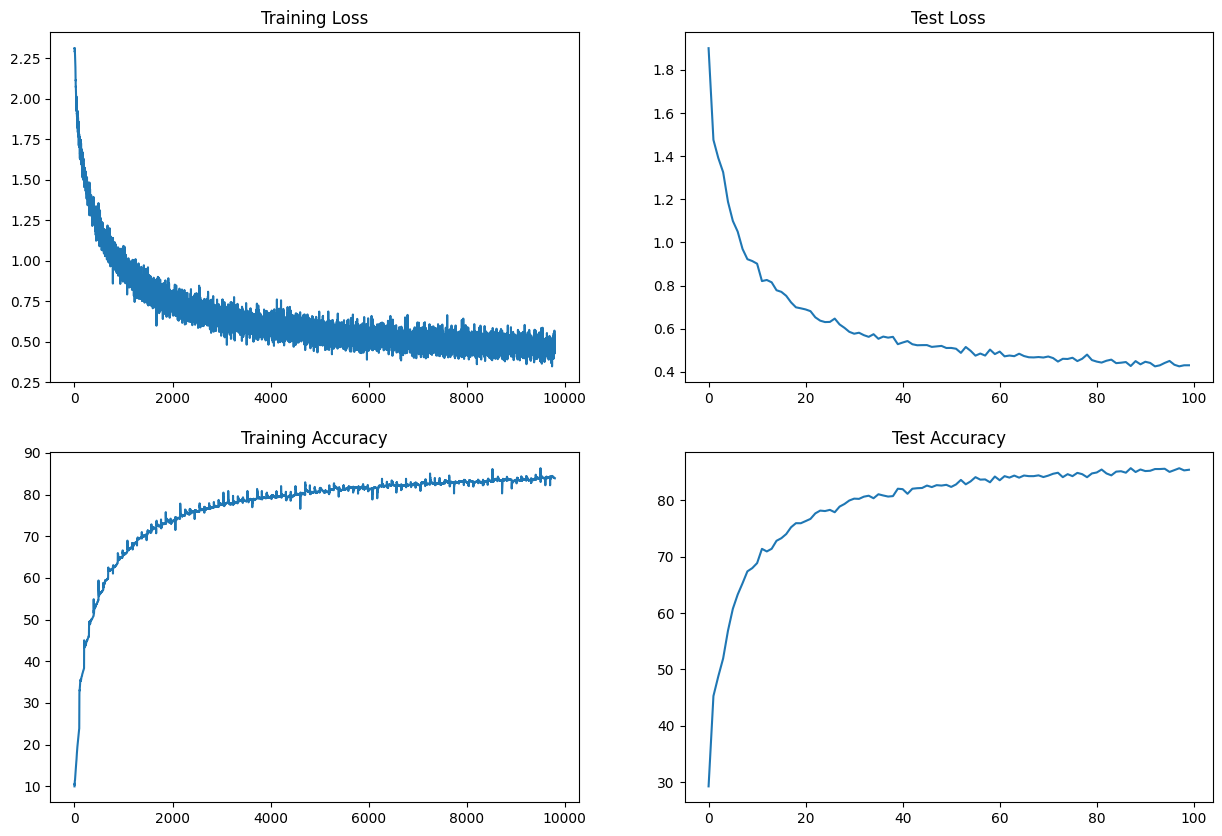

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")